In [13]:
import numpy as np
import torch
from typing import Dict, Tuple

# ================================
# 설정값
# ================================
K = 3  # Nearest Neighbors 수
USE_GPU = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_GPU else "cpu")

# ================================
# Step 1: Normal DB 구성
# ================================
def build_normal_database(train_X, train_Y):
    normal_mask = (train_Y == 0)
    normal_db = torch.tensor(train_X[normal_mask], dtype=torch.float32).to(DEVICE)
    return normal_db

# ================================
# Step 2: 거리 계산 함수
# ================================
def compute_distances(fault_input, normal_db):
    diff = normal_db - fault_input.unsqueeze(0)  # (N_normal, 50, 11)
    distances = torch.mean(diff ** 2, dim=(1, 2))  # (N_normal,)
    return distances

# ================================
# Step 3: 보정 함수
# ================================
def normalize_by_knn(fault_input, normal_db, k=3, method='mean'):
    distances = compute_distances(fault_input, normal_db)
    topk_indices = torch.topk(distances, k=k, largest=False).indices  # k개 선택
    topk_seqs = normal_db[topk_indices]  # shape: (k, 50, 11)
    if method == 'mean':
        return torch.mean(topk_seqs, dim=0)
    elif method == 'first':
        return topk_seqs[0]
    else:
        raise ValueError("지원되지 않는 method입니다: mean / first 중 선택하세요.")

# ================================
# 전체 파이프라인 예시
# ================================
def knn_normalize_batch(test_X, normal_db, k=3, method='mean'):
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(DEVICE)
    normalized_list = []
    for i in range(test_X_tensor.shape[0]):
        normalized = normalize_by_knn(test_X_tensor[i], normal_db, k=k, method=method)
        normalized_list.append(normalized.cpu().numpy())
    return np.stack(normalized_list, axis=0)

class Model2Module:
    """
    Model2: 고장 시점 이후 정상화 (KNN 기반, MSE 사용)
    + Fault별 정상-고장 평균 거리 분석 지원
    """

    def __init__(self, normal_db: np.ndarray):
        """
        Args:
            normal_db: (N_normal, 50, 11) 형태의 정상 시퀀스 DB (np.ndarray 또는 tensor 허용)
        """
        if isinstance(normal_db, np.ndarray):
            self.normal_db = torch.tensor(normal_db, dtype=torch.float32).to(DEVICE)
        elif isinstance(normal_db, torch.Tensor):
            self.normal_db = normal_db.to(DEVICE)
        else:
            raise TypeError("normal_db는 numpy.ndarray 또는 torch.Tensor 여야 합니다.")

    def normalize_after_fault(self,
                              input_sequence: np.ndarray,
                              fault_time: int,
                              k: int = 3,
                              method: str = 'mean') -> Tuple[np.ndarray, Dict]:
        if fault_time is None or fault_time >= input_sequence.shape[0]:
            print("[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.")
            return input_sequence, {'normalized': False}

        post_fault_input = input_sequence[fault_time:]
        normalized = knn_normalize_batch(
            post_fault_input,
            self.normal_db,
            k=k,
            method=method
        )

        full_output = np.concatenate([
            input_sequence[:fault_time],
            normalized
        ], axis=0)

        return full_output, {
            'normalized': True,
            'fault_time': fault_time,
            'num_normalized_windows': len(post_fault_input)
        }

    def analyze_fault_distance(self, 
                           fault_data: np.ndarray,
                           normal_data: np.ndarray = None) -> float:
        """
        Fault 평균 시퀀스와 Normal 평균 시퀀스 간의 MSE 거리 계산
        """
        if normal_data is None:
            normal_data = self.normal_db.cpu().numpy()  # 🔧 수정: Tensor → numpy

        mean_fault = np.mean(fault_data, axis=0)   # (50, 11)
        mean_normal = np.mean(normal_data, axis=0) # (50, 11)

        mse = np.mean((mean_fault - mean_normal) ** 2)
        return mse


    def analyze_all_faults(self, fault_db: Dict[int, np.ndarray]) -> Dict[int, float]:
        results = {}
        for fault, data in fault_db.items():
            dist = self.analyze_fault_distance(data)
            results[fault] = dist
        return results

In [ ]:
import numpy as np

# ===========================================
# 1. 데이터 로드
# ===========================================
train_X = np.load('windows2/train/merged_train_data/train_X.npy')  # shape: (N0, 50, 11)
train_Y = np.load('windows2/train/merged_train_data/train_Y.npy')  # shape: (N0,)

test_X = np.load('windows2/test/merged_test_data/test_X.npy')      # shape: (Nf, 50, 11)
test_Y = np.load('windows2/test/merged_test_data/test_Y.npy')      # shape: (Nf,)

# ===========================================
# 2. 정상 DB 생성 (라벨 == 0)
# ===========================================
normal_db = build_normal_database(train_X, train_Y).cpu().numpy()  # torch → numpy 변환

# ===========================================
# 3. Model2Module 초기화
# ===========================================
model2 = Model2Module(normal_db)

# ===========================================
# 4. 특정 fault 클래스 테스트 (예: fault 8)
# ===========================================
fault_label = 6
fault_mask = (test_Y == fault_label)
fault_data = test_X[fault_mask]   # shape: (N_f8, 50, 11)

assumed_fault_time = 10  # 전체 시퀀스에 동일한 고장 시점 적용

# ===========================================
# 5. 전체 고장 시퀀스 정상화
# ===========================================
normalized_all = []
infos_all = []

for idx in range(fault_data.shape[0]):
    input_seq = fault_data[idx:idx+1]  # shape: (1, 50, 11)
    
    normalized_seq, info = model2.normalize_after_fault(
        input_sequence=input_seq,
        fault_time=assumed_fault_time,
        k=3,
        method='mean'
    )
    
    normalized_all.append(normalized_seq.squeeze(0))  # (50, 11)
    infos_all.append(info)

normalized_all = np.array(normalized_all)  # shape: (N_f8, 50, 11)

print(f"▶ Fault-{fault_label} 전체 정상화 완료 (총 {len(normalized_all)} 시퀀스)")
print(f"▶ 예시 보정 정보 (index 0): {infos_all[0]}")

# ===========================================
# 6. Fault vs Normal 평균 거리 계산 (MSE 기반)
# ===========================================
mse_distance = model2.analyze_fault_distance(fault_data)
print(f"▶ Fault-{fault_label} vs Normal 평균 MSE 거리: {mse_distance:.4f}")

# ===========================================
# 7. 전체 Fault별 평균 거리 분석
# ===========================================
fault_classes = np.unique(test_Y)
fault_db = {
    int(f): test_X[test_Y == f] for f in fault_classes if f != 0
}
all_distances = model2.analyze_all_faults(fault_db)

print("▶ Fault별 MSE 거리 분석 결과:")
for fault_num, dist in all_distances.items():
    print(f"  - Fault {fault_num}: {dist:.4f}")

In [66]:
from typing import Union
import numpy as np
from sklearn.decomposition import PCA


class PCABasedNormalizer:
    def __init__(self, normal_db: np.ndarray, n_components: int = 5):
        """
        PCA 기반 보정기 초기화
        Args:
            normal_db (np.ndarray): 정상 DB, shape (N, T, D)
            n_components (int): 차원 축소할 주성분 수
        """
        N, T, D = normal_db.shape
        self.n_components = n_components
        self.T = T
        self.D = D

        # 각 시점별 PCA 수행
        self.pca_models = []
        self.normal_proj = []
        for t in range(T):
            pca = PCA(n_components=n_components)
            X_t = normal_db[:, t, :]
            pca.fit(X_t)
            proj = pca.transform(X_t)
            self.pca_models.append(pca)
            self.normal_proj.append(proj)
        self.normal_proj = np.array(self.normal_proj)  # (T, N, n_components)

    def project(self, seq: np.ndarray) -> np.ndarray:
        """
        시퀀스를 PCA 공간으로 투영
        Args:
            seq (np.ndarray): shape (T, D)
        Returns:
            projected (np.ndarray): shape (T, n_components)
        """
        projected = np.zeros((self.T, self.n_components))
        for t in range(self.T):
            projected[t] = self.pca_models[t].transform(seq[t].reshape(1, -1))[0]
        return projected

    def compute_distances(self, projected_seq: np.ndarray) -> np.ndarray:
        """
        PCA 투영 공간에서 거리 계산 (MSE)
        Args:
            projected_seq (np.ndarray): shape (T, n_components)
        Returns:
            distances (np.ndarray): shape (N,)
        """
        diff = self.normal_proj - projected_seq[None, :, :]  # (N, T, n_components)
        distances = np.mean(diff ** 2, axis=(1, 2))  # (N,)
        return distances
    
    def knn_normalize(self,
                      fault_sequence: np.ndarray,
                      k: int = 3,
                      method: str = 'mean',
                      return_pca_vector: bool = False
                      ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        assert fault_sequence.shape == (self.T, self.D)

        normalized_sequence = []
        corrected_pca_sequence = []

        for t in range(self.T):
            pca = self.pca_models[t]
            normal_proj_t = self.normal_proj[:, t, :]  # (N, n_components)
            fault_proj_t = pca.transform(fault_sequence[t].reshape(1, -1))  # (1, n_components)

            dists = np.linalg.norm(normal_proj_t - fault_proj_t, axis=1)
            topk_indices = np.argsort(dists)[:k]
            topk_proj = normal_proj_t[topk_indices]

            if method == 'mean':
                corrected_proj = np.mean(topk_proj, axis=0)
            elif method == 'first':
                corrected_proj = topk_proj[0]
            else:
                raise ValueError("지원되지 않는 method입니다: 'mean' 또는 'first'")

            reconstructed = pca.inverse_transform(corrected_proj.reshape(1, -1)).reshape(-1)

            normalized_sequence.append(reconstructed)
            corrected_pca_sequence.append(corrected_proj)

        normalized_sequence = np.stack(normalized_sequence, axis=0)
        corrected_pca_sequence = np.stack(corrected_pca_sequence, axis=0)

        if return_pca_vector:
            return normalized_sequence, corrected_pca_sequence
        else:
            return normalized_sequence

In [90]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_detection(labels: np.ndarray,
                       scores: np.ndarray,
                       threshold: float,
                       fault_start_idx: int
                       ) -> dict:
    """
    고장 탐지 평가 지표 계산

    Args:
        labels (np.ndarray): 실제 라벨 (0: 정상, 1: 고장), shape (N,)
        scores (np.ndarray): 이상 점수 (높을수록 이상), shape (N,)
        threshold (float): 이상 판단 임계값
        fault_start_idx (int): 실제 고장 시작 인덱스 (ground truth)

    Returns:
        dict: {
            'accuracy': float,
            'precision': float,
            'recall': float,
            'f1': float,
            'detection_delay': int or None,  # 탐지 지연, 못 찾으면 None
            'detected_index': int or None    # 최초 탐지 시점 인덱스
        }
    """

    # 이상 여부 예측 (threshold 기반)
    preds = (scores >= threshold).astype(int)

    # 평가 지표 계산
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)

    # 실제 고장 시작 인덱스 이후에서 최초 탐지 시점 찾기
    detected_index = None
    for idx in range(fault_start_idx, len(preds)):
        if preds[idx] == 1:
            detected_index = idx
            break

    # 탐지 지연 계산
    if detected_index is not None:
        detection_delay = detected_index - fault_start_idx
        if detection_delay < 0:
            detection_delay = 0
    else:
        detection_delay = None

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'detection_delay': detection_delay,
        'detected_index': detected_index
    }

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드 (사용자 환경에 맞게 경로 수정)
train_X = np.load('windows2/train/merged_train_data/train_X.npy')  # (N_train, 50, 11)
train_Y = np.load('windows2/train/merged_train_data/train_Y.npy')  # (N_train,)

test_X = np.load('windows2/test/merged_test_data/test_X.npy')      # (N_test, 50, 11)
test_Y = np.load('windows2/test/merged_test_data/test_Y.npy')      # (N_test,)

# 2. 정상 DB 구축 (train_Y==0인 데이터만)
normal_db = build_normal_database(train_X, train_Y).cpu().numpy()  # torch tensor → numpy 변환

# 3. Model2Module, PCABasedNormalizer 초기화
model2 = Model2Module(normal_db)
pca_normalizer = PCABasedNormalizer(normal_db, n_components=9)

# 4. 고장 시퀀스 선택 (예: test set 첫 번째 샘플)
fault_seq = test_X[0]  # shape (50, 11)

# 5. PCA 기반 KNN 정상화 수행
normalized_seq_pca, corrected_pca = pca_normalizer.knn_normalize(
    fault_seq,
    k=3,
    method='mean',
    return_pca_vector=True
)

# 6. Model2Module 기반 고장 이후 정상화
fault_time = 160
normalized_seq_model2, info = model2.normalize_after_fault(
    fault_seq,
    fault_time=fault_time,
    k=3,
    method='mean'
)

print("Model2 보정 완료 여부:", info['normalized'])

# 7. 원본 vs PCA 정상화 비교 시각화 (예: 타임스텝 3)
time_step = 3
plt.figure(figsize=(10, 4))
plt.plot(fault_seq[time_step], label='Original Fault Sequence (t=3)')
plt.plot(normalized_seq_pca[time_step], label='PCA Normalized (t=3)')
plt.plot(normalized_seq_model2[time_step], label='Model2 Normalized (t=3)')
plt.legend()
plt.title("Original vs PCA vs Model2 Normalized at timestep 3")
plt.show()

# 8. 추가: test_X 배치에 대해 Model2 정상화 적용 (fault_time 동일 가정)
normalized_test_X = []
for i in range(len(test_X)):
    norm_seq, _ = model2.normalize_after_fault(
        test_X[i],
        fault_time=fault_time,
        k=3,
        method='mean'
    )
    normalized_test_X.append(norm_seq)
normalized_test_X = np.array(normalized_test_X)

print("배치 정상화 완료, shape:", normalized_test_X.shape)

# 9. 이상 점수 계산 예시 (Model2 거리 기반)
def anomaly_score(seq):
    # 복원 후 MSE 계산 등으로 변형 가능
    return np.mean((seq - np.mean(normal_db, axis=0))**2)

scores = np.array([anomaly_score(seq) for seq in normalized_test_X])
labels = (test_Y > 0).astype(int)  # 0: 정상, 1: 고장

# 10. 평가 지표 계산 (evaluate_detection은 이전 제공 함수)
threshold = np.percentile(scores, 95)
result = evaluate_detection(labels, scores, threshold, fault_start_idx=fault_time)

print("평가 결과:", result)

[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
Model2 보정 완료 여부: False


[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 유효하지 않습니다. 입력 그대로 반환합니다.
[Model2] 고장 시점이 

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sequence_comparison(original_seq: np.ndarray, 
                             normalized_seq: np.ndarray, 
                             sensor_indices: list = [0], 
                             title_prefix: str = ""):
    """
    정상화 전후 시계열을 센서별로 시각화
    Args:
        original_seq: (50, 11) shape, 정상화 전 시퀀스
        normalized_seq: (50, 11) shape, 정상화된 시퀀스
        sensor_indices: 시각화할 센서 인덱스 리스트
        title_prefix: 그래프 제목 앞부분
    """
    for sensor_idx in sensor_indices:
        plt.figure(figsize=(12, 4))
        plt.plot(original_seq[:, sensor_idx], label='Fault Input', linestyle='-', color='r')
        plt.plot(normalized_seq[:, sensor_idx], label='KNN Normalized', linestyle='--', color='b')
        plt.title(f"{title_prefix} xmv_{sensor_idx+1}: Fault vs Normalized")
        plt.xlabel("Timestep (0~49)")
        plt.ylabel("Sensor Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

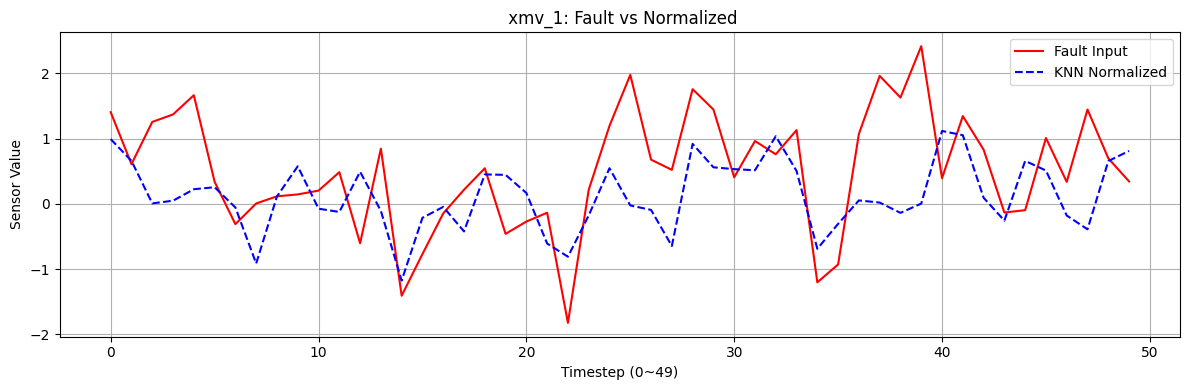

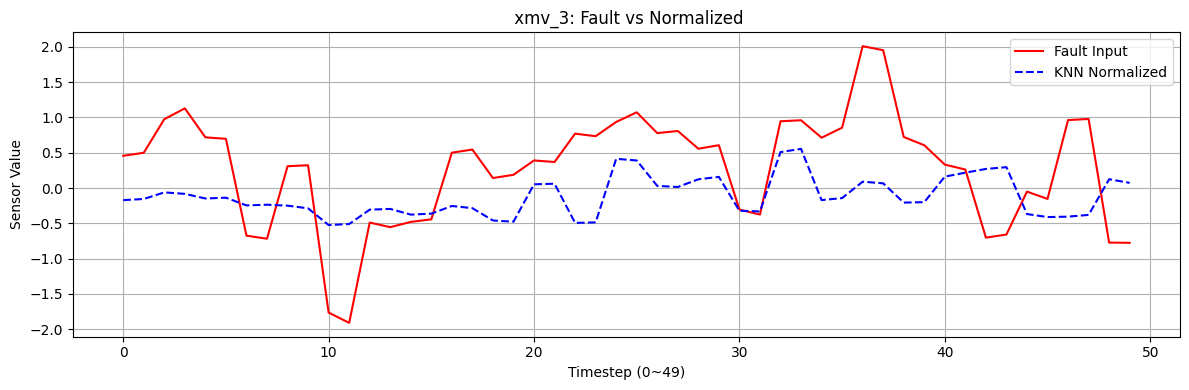

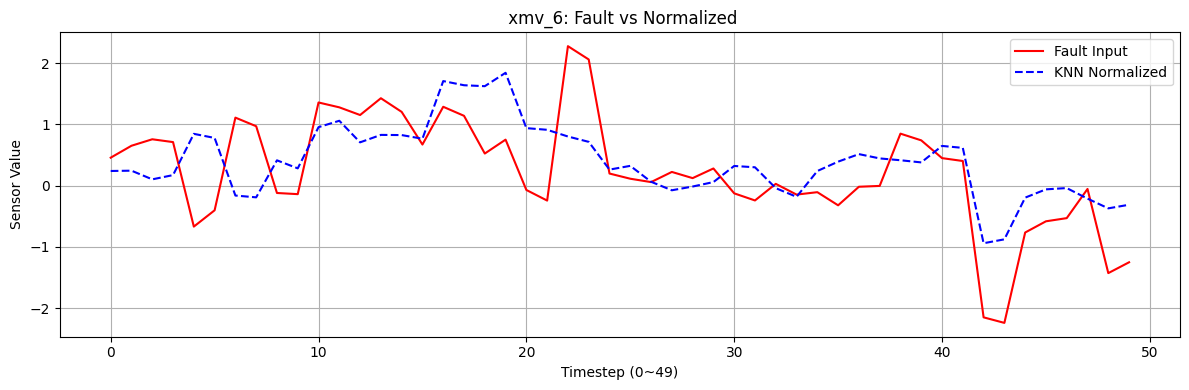

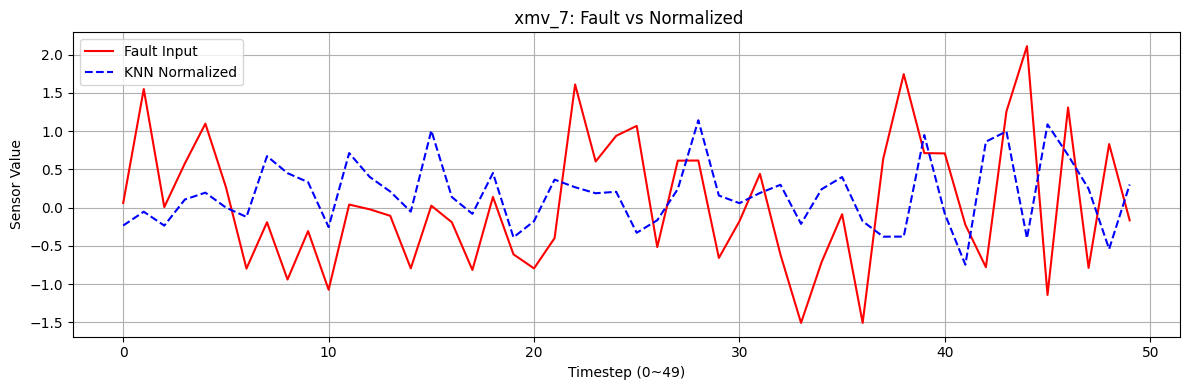

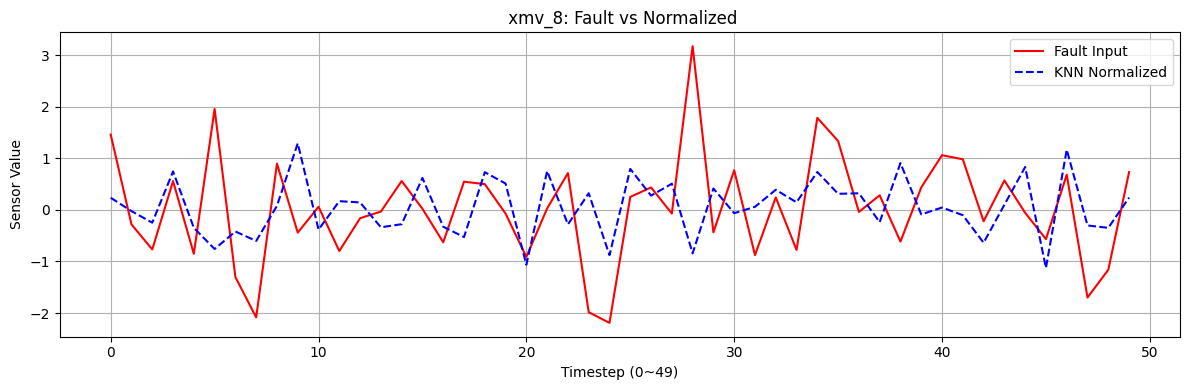

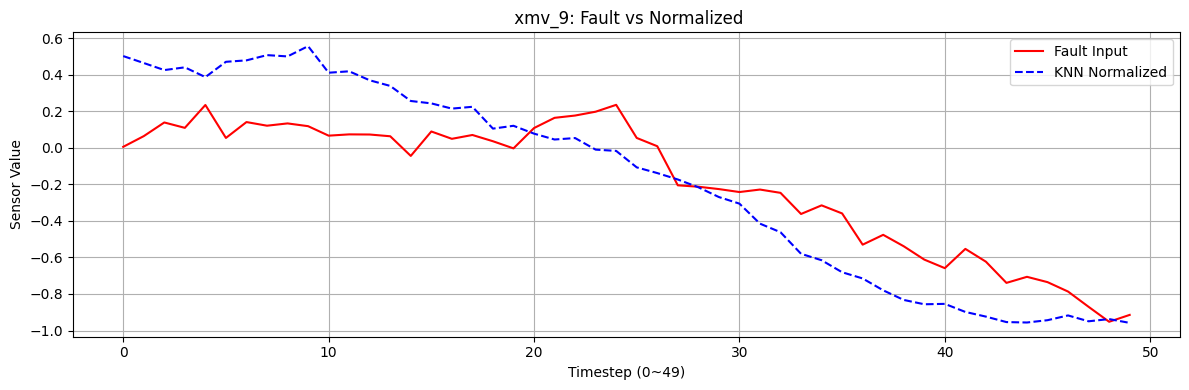

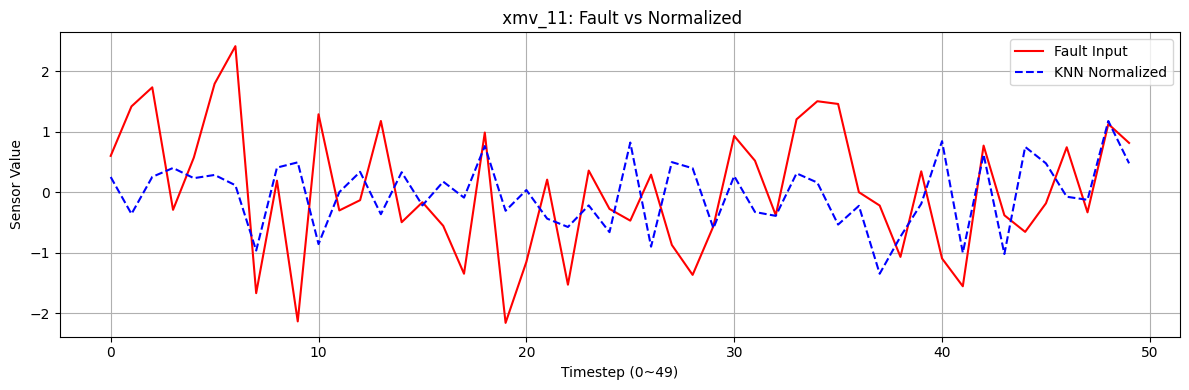

In [92]:
sample_idx = 3 # fault type
fault_seq = fault_data[sample_idx]                         # numpy ndarray (50, 11)

# 1) 정상 DB tensor 변환 (초기화 시 1회)
normal_db_tensor = torch.tensor(normal_db, dtype=torch.float32).to(DEVICE)

# 2) 샘플 fault 시퀀스 tensor 변환
fault_seq_tensor = torch.tensor(fault_seq, dtype=torch.float32).to(DEVICE)

# 3) KNN 정상화 실행
normalized_seq_tensor = normalize_by_knn(fault_seq_tensor, normal_db_tensor, k=3, method='mean')

# 4) numpy 변환 후 시각화
normalized_seq = normalized_seq_tensor.cpu().numpy()
plot_sequence_comparison(fault_seq, normalized_seq, sensor_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])